# Using Decision Tree & Naive Bayes to classify Pokemon

## <font color="red">Import libraries</font>

In [17]:
import gc
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import utils as ut
import decisionTree as dt
import naiveBayes as nb
from sklearn.metrics import roc_curve, auc

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%reload_ext autoreload

In [19]:
# Set packages options
plt.rcParams["figure.figsize"] = (9, 5)

## <font color="red">Define constants and functions</font>

In [20]:
# Constants
TypeColorMappings = {"Water": "#6890F0", "Fire": "#F08030", "Grass": "#78C850",
                     "Dark": "#705848", "Electric": "#F8D030", "Flying": "#A890F0",
                     "Normal": "#A8A878", "Fighting": "#C03028", "Poison": "#A040A0",
                     "Ground": "#E0C068", "Psychic": "#F85888", "Rock": "#B8A038", 
                     "Ice": "#98D8D8", "Bug": "#A8B820", "Dragon": "#7038F8", 
                     "Ghost": "#705898", "Steel": "#B8B8D0", "Fairy": "#EE99AC"}

DropColumns = ["Pokedex", "Name", "Generation", "Category"]

def getColorList(typeCounts):
    assert type(typeCounts) == pd.core.series.Series, "Argument must be a Series object"
    return [TypeColorMappings[pokemonType] for pokemonType in typeCounts.index]

def getRandomColor():
    return "#%02X%02X%02X" % (random.randint(0,255), random.randint(0,255), random.randint(0,255))

def filterByValue(dataFrame, column, value):
    return dataFrame[dataFrame[column] == value]

## <font color="red">Load the data from file</font>

In [21]:
# Load the Pokemon data
fileName = r'.\Pokemon_Cleaned.tsv'
columnTypes = {"Name": str, "Category": str, "Type 1": str, "Type 2": str, 
               "Ability 1": str, "Ability 2": str, "Ability 3": str, "Group": str}
data = pd.read_csv(fileName, header=0, sep='\t', dtype=columnTypes)
data.sample(5)

,Generation,Pokedex,Name,Category,Type 1,Type 2,Ability 1,Ability 2,Ability 3,MaleRatio,...,EggGroup 1,EggGroup 2,HP,Attack,Defense,Sp.Attack,Sp.Defense,Speed,Total,Group
591,5.0,505.0,Watchog,Lookout Pokemon,Normal,None,Keen Eye,Analytic,Illuminate,50.0,...,Field,None,60.0,85.0,69.0,60.0,69.0,77.0,420,Ordinary
568,4.0,484.0,Palkia,Spatial Pokemon,Water,Dragon,Telepathy,Pressure,None,0.0,...,Undiscovered,None,90.0,120.0,100.0,150.0,120.0,100.0,680,Legendary
211,2.0,176.0,Togetic,Happiness Pokemon,Fairy,Flying,Serene Grace,Hustle,Super Luck,87.5,...,Flying,Fairy,55.0,40.0,85.0,80.0,105.0,40.0,405,Ordinary
279,2.0,239.0,Elekid,Electric Pokemon,Electric,None,Vital Spirit,Static,None,75.0,...,Undiscovered,None,45.0,63.0,37.0,65.0,55.0,95.0,360,Ordinary
758,6.0,656.0,Froakie,Bubble Frog Pokemon,Water,None,Torrent,Protean,None,87.5,...,Water 1,None,41.0,56.0,40.0,62.0,44.0,71.0,314,Ordinary


## <font color="red">Plot graphs to visualize and understand the data</font>

### Group Distribution

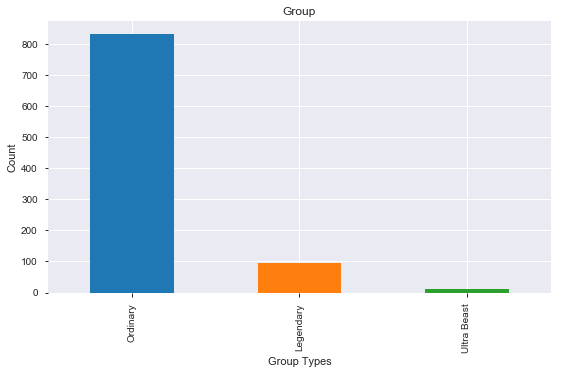

In [22]:
# Plot Group occurences to see the distributions
groupFig, groupAxes = plt.subplots(nrows=1, ncols=1)
groupCounts = data["Group"].value_counts()
groupAxe = groupCounts.plot(title="Group", kind="bar")
groupAxe.set(xlabel="Group Types", ylabel="Count")
plt.show()

### Scatter Plots of Continous Features

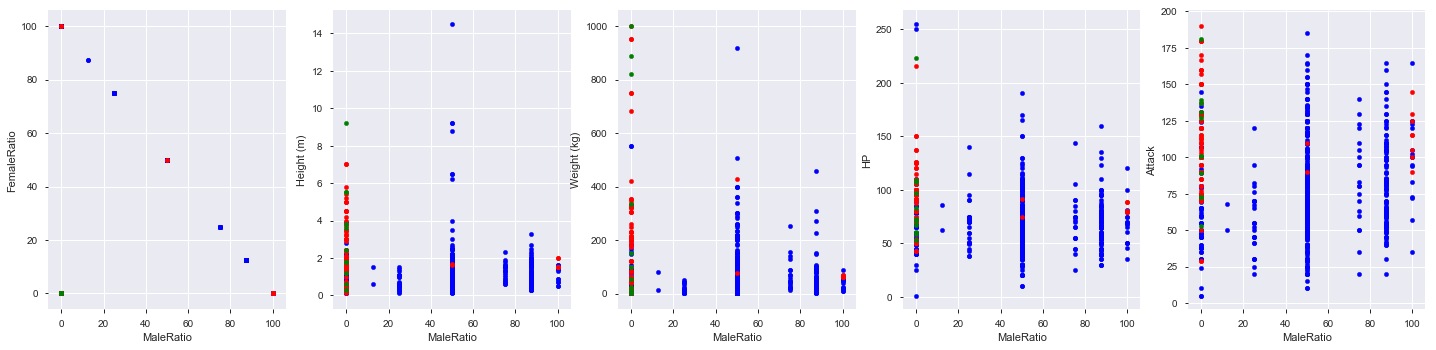

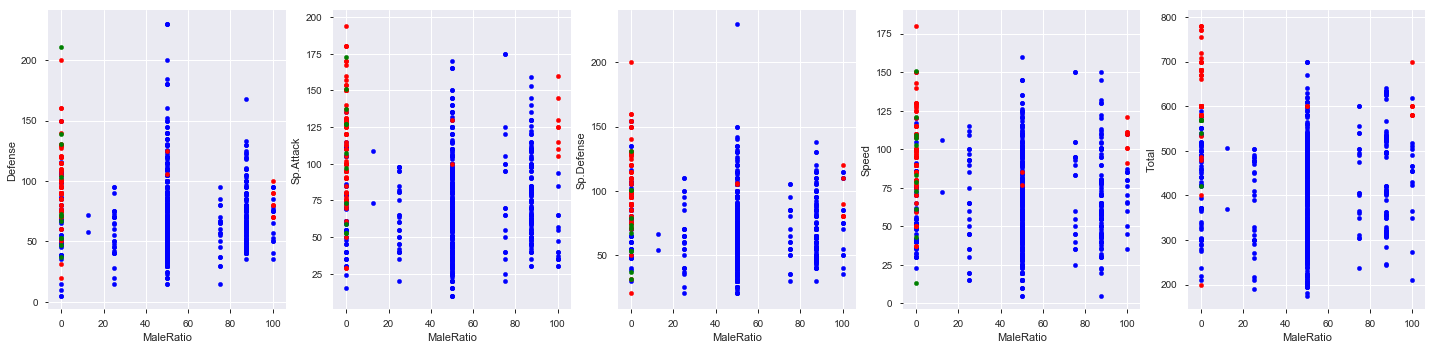

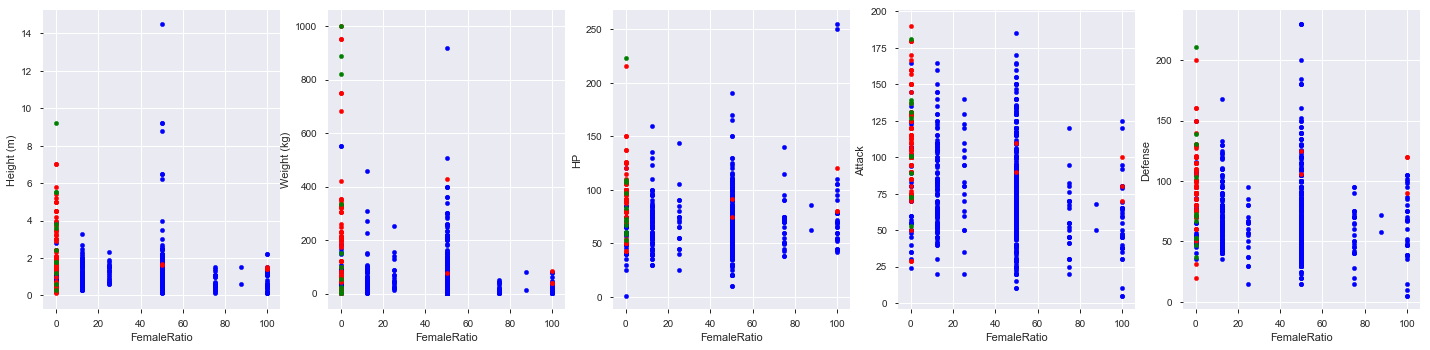

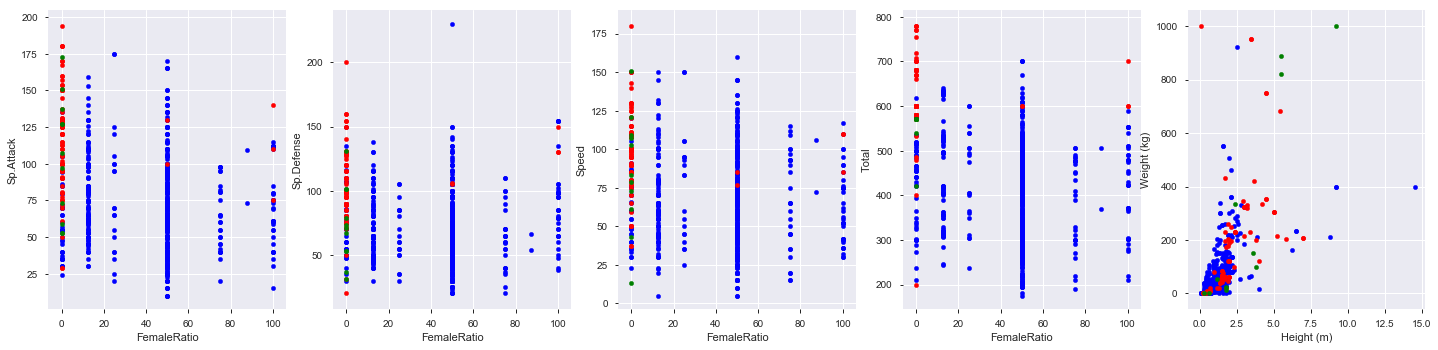

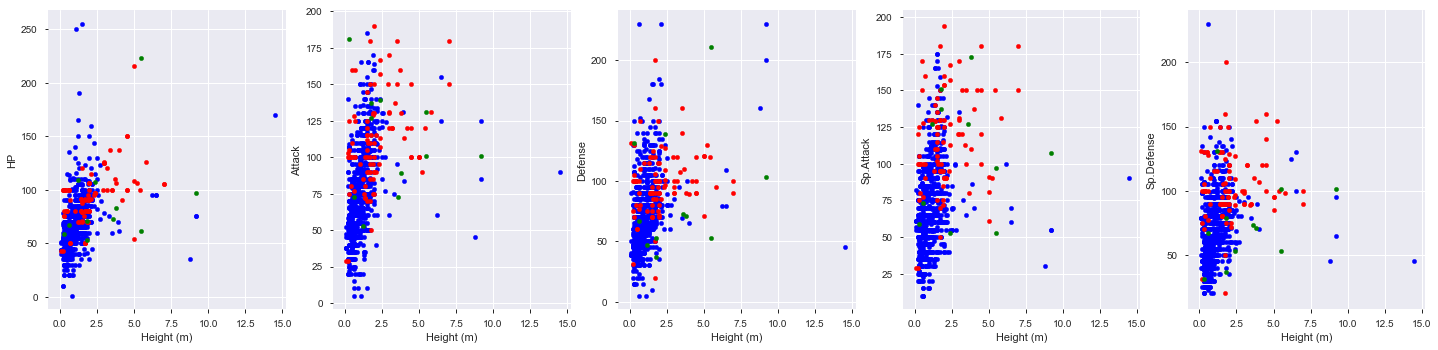

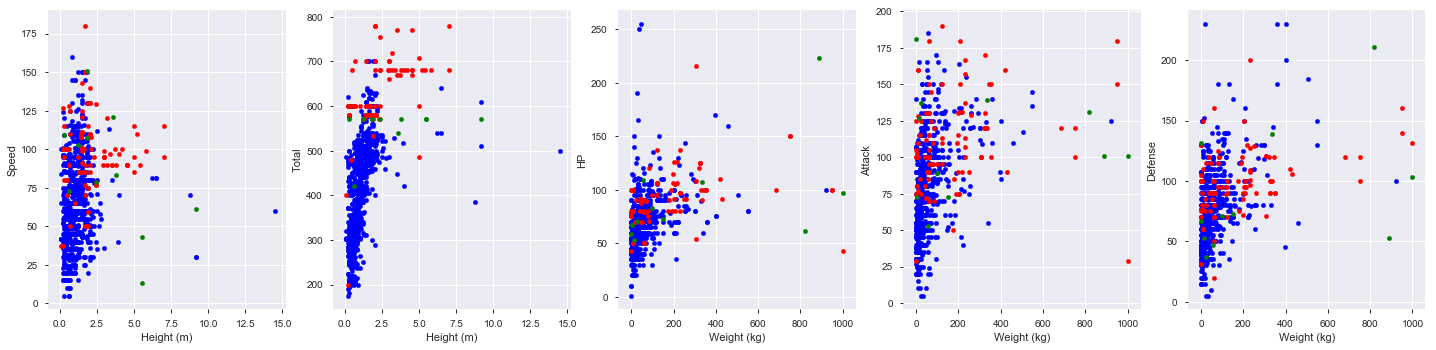

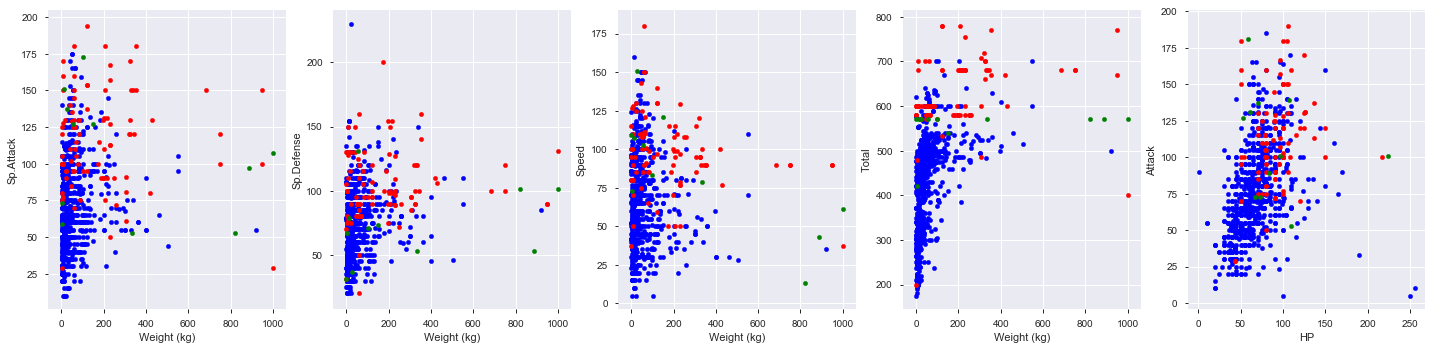

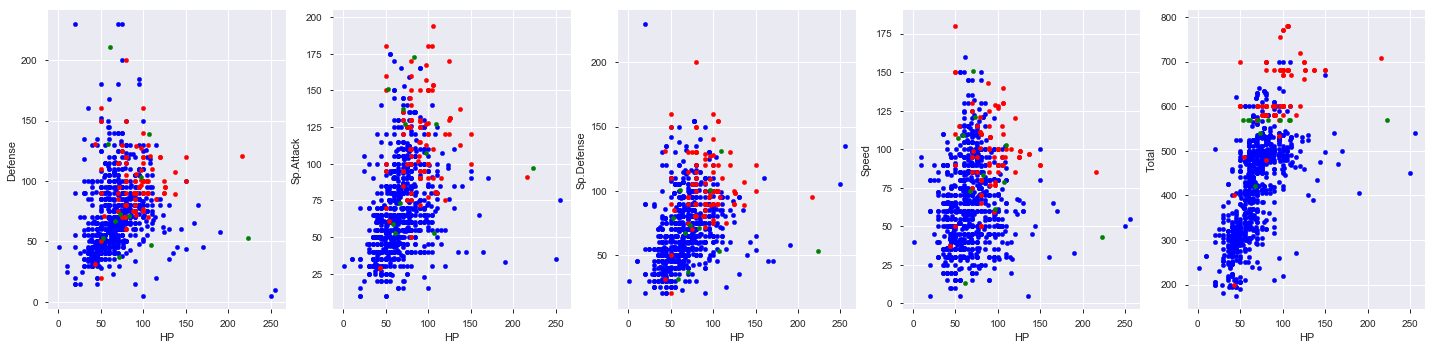

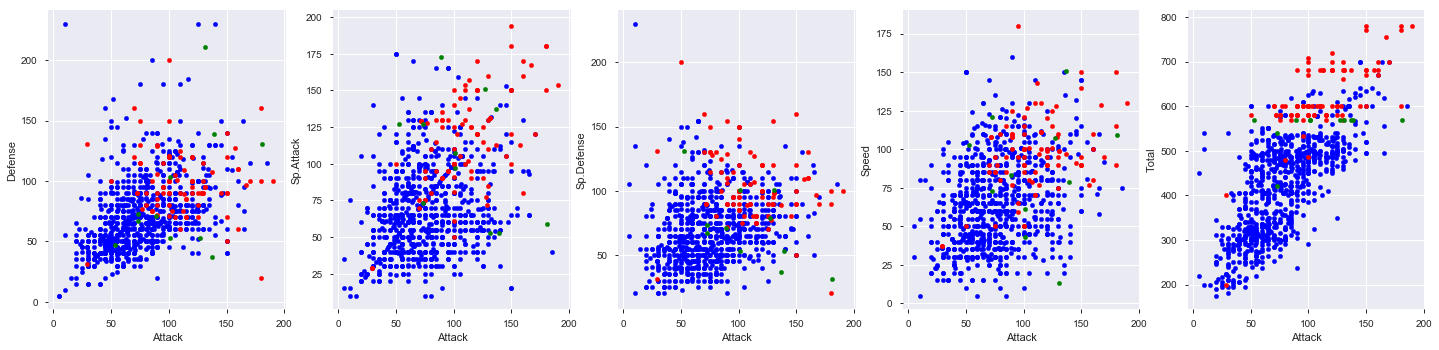

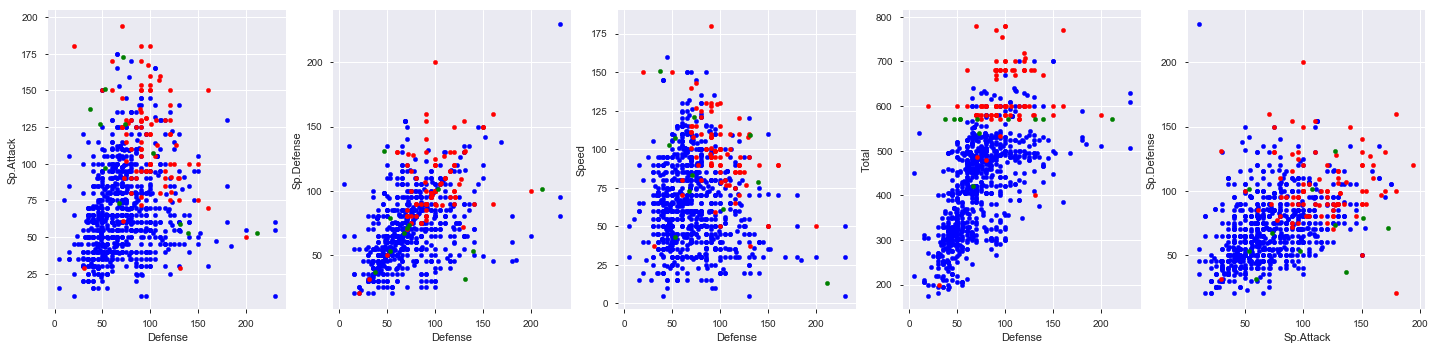

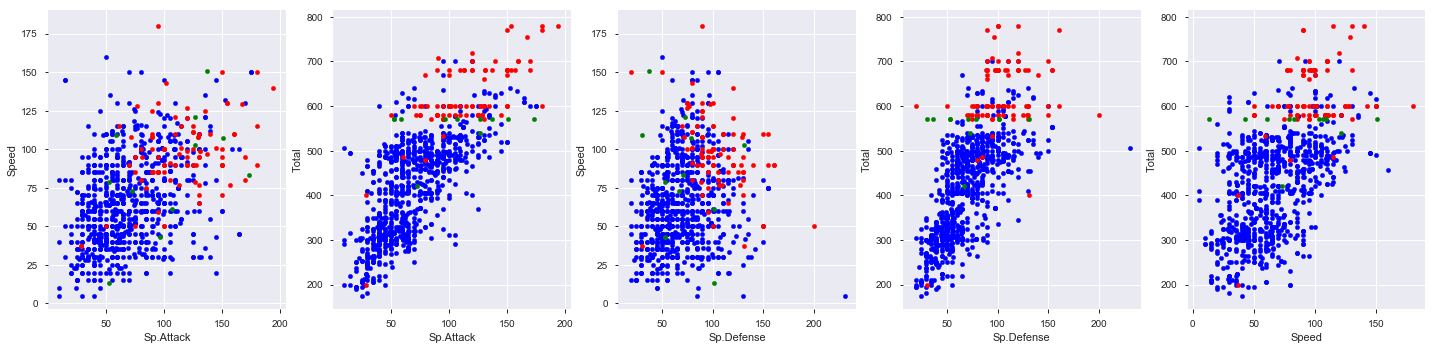

In [23]:
ordi = filterByValue(data, "Group", "Ordinary")
lg = filterByValue(data, "Group", "Legendary")
ub = filterByValue(data, "Group", "Ultra Beast")

continuousFeatures = data.select_dtypes(include=[np.int64, np.float64]).drop(["Generation", "Pokedex"], axis=1)

# Get each pair of of the continous features but don't include redundant combinations
combinations = []
for x in continuousFeatures:    
    for y in continuousFeatures:
        if (x != y) and (not ((x, y) in combinations or (y, x) in combinations)):
            combinations.append((x, y))

# Plot all the continous features in scatter plots
numPerRow = 5
for i in range(0, len(combinations), numPerRow):
    fig, axes = plt.subplots(1, ncols=numPerRow, figsize=(15, 5.5))
    fig.subplots_adjust(right=1.4)
    for j in range(numPerRow):
        x, y = combinations[i+j]
        axe = ordi.plot(x, y, kind="scatter", c="b", ax=axes[j])
        lg.plot(x, y, kind="scatter", c="r", ax=axe)
        ub.plot(x, y, kind="scatter", c="g", ax=axe)

### Histograms of Continuous Features

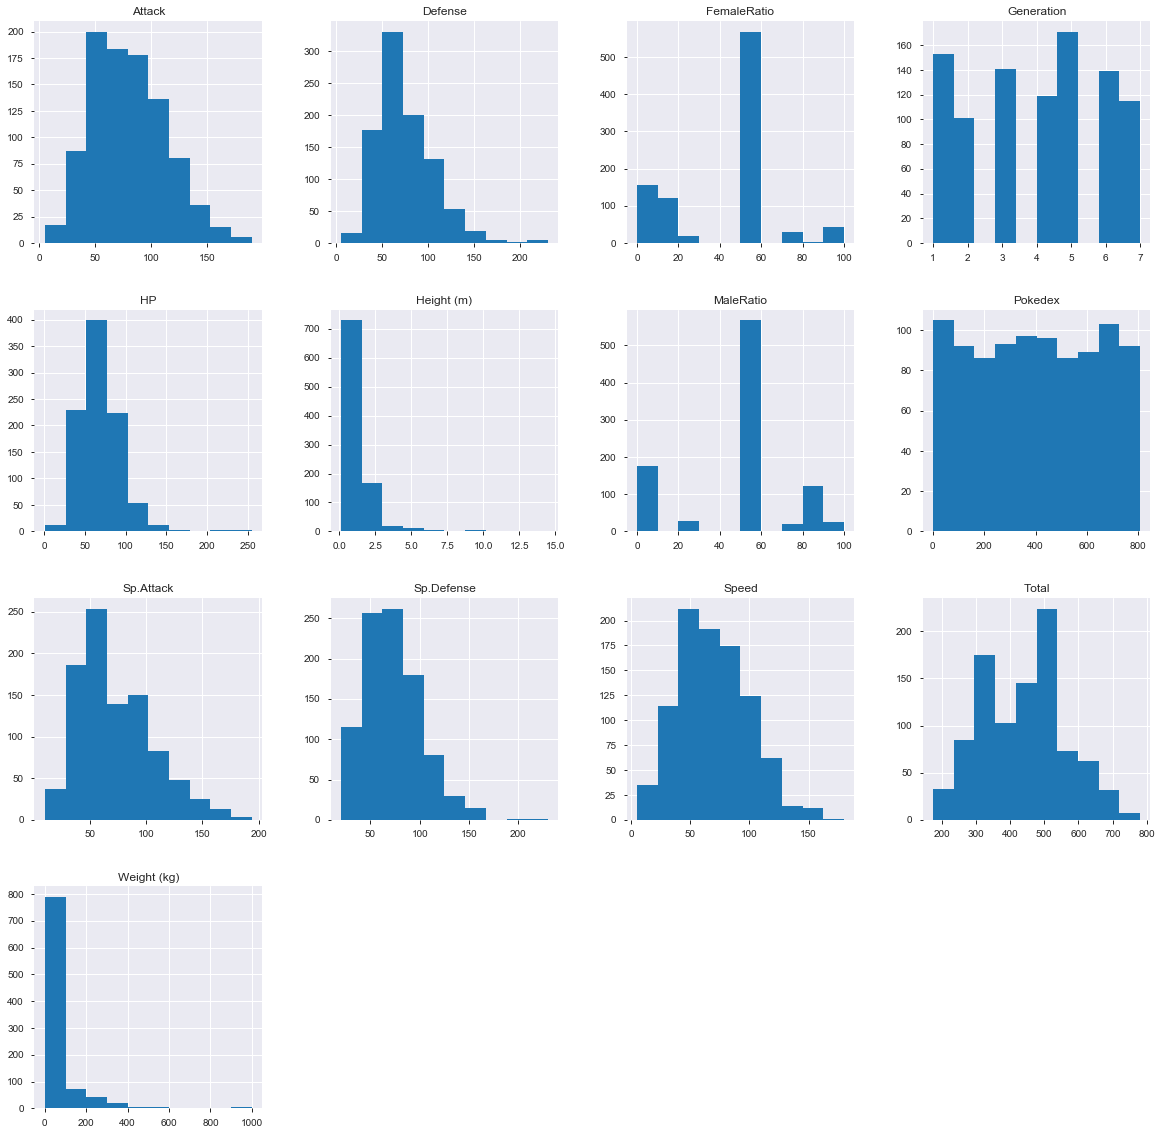

In [24]:
data.hist(figsize=(20,20))
plt.show()

We can see that features with uniform distribution may not contribute much to Decision Tree model because the model will be biased toward to those features since there is more entropy within those features.

### Box Plot of Total & Group

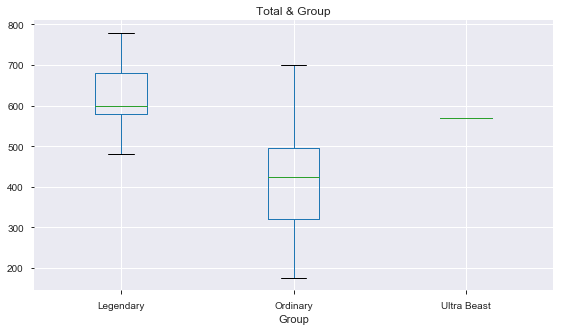

In [25]:
data.boxplot("Total", "Group")
plt.title("Total & Group")
plt.suptitle("")
plt.show()

<p> According to the boxplot above, we can see that despite having a small quanity in size, <b>Legendary Pokemon</b> has the highest <b>Total</b> stats compared to the other 2 groups.</p>

In [26]:
# Get data profile. Only use continuous features
profile = pdp.ProfileReport(data.select_dtypes(include=[np.int64, np.float64]))
profile.to_file("Profile.html")

## <font color="red"/>Training & Test Data</font>

In [27]:
Target = "Group"
Labels = data[Target].unique()
LabelColors = {"Ordinary": "b", "Legendary": "r", "Ultra Beast": "g"}

ReducedData = data.drop(DropColumns, axis=1)
Training, Test = ut.splitData(Target, ReducedData, 0.70)

In [28]:
print(Training[Target].value_counts())
print(Test[Target].value_counts())

Ordinary       582
Legendary       66
Ultra Beast      9
Name: Group, dtype: int64
Ordinary       251
Legendary       29
Ultra Beast      2
Name: Group, dtype: int64


## <font color="red">Decision Tree</font>

In [29]:
# Use Decision Tree to train on the training set and predict on the test set
dtree = dt.DecisionTree(Target, maxDepth=3)
dtree.train(Training)
dtPred = dtree.classify(Test.drop([Target], axis=1))

Function "train" took 13.00 seconds to complete


In [31]:
dtMatrix = ut.buildConfusionMatrix(dtPred["Prediction"], Test[Target], Labels)
dtPrecisions, dtRecalls = ut.getPrecisionsAndRecalls(dtMatrix, Labels)
dtFScores = ut.computeFScores(dtPrecisions, dtRecalls)
"Error {0:.2f}%".format(ut.computeError(dtPred["Prediction"], Test["Group"]) * 100)

'Error 1.42%'

### Decision Tree Confusion Matrix

In [32]:
dtMatrix

,Predicted Legendary,Predicted Ordinary,Predicted Ultra Beast,Total
Actual Legendary,25,4,0,29
Actual Ordinary,0,251,0,251
Actual Ultra Beast,0,0,2,2
Total,25,255,2,282


In [33]:
dtPrecisions

{'Legendary': 1.0, 'Ordinary': 0.984313725490196, 'Ultra Beast': 1.0}

In [34]:
dtRecalls

{'Legendary': 0.8620689655172413, 'Ordinary': 1.0, 'Ultra Beast': 1.0}

In [35]:
print("Average across all labels:", dtFScores[0])
dtFScores[1]

Average across all labels: 0.9726735958620015


{'Legendary': 0.9259259259259259,
 'Ordinary': 0.992094861660079,
 'Ultra Beast': 1.0}

### Decision Tree ROC Curve

Text(0.5, 0, 'False Positive Rate')

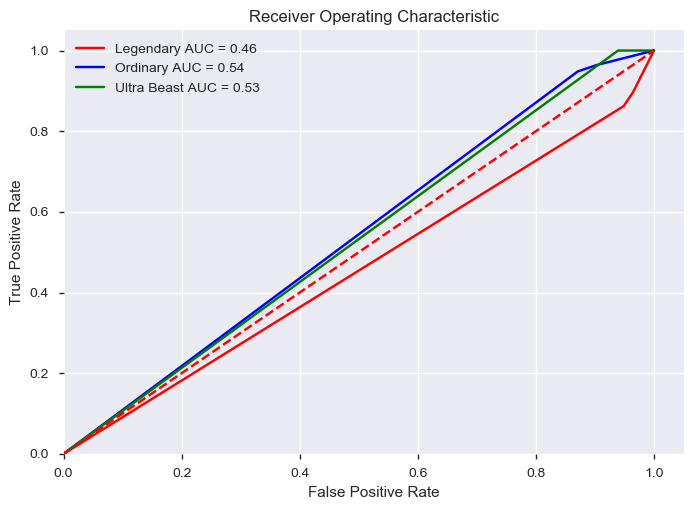

In [36]:
# For each label, treat other labels as "negative"
for label in Labels:
    c = LabelColors[label]
    fpr, tpr, rocThresholds = roc_curve(y_true=Test[Target], y_score=[v[1] for v in dtPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, rocAuc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0, 1.05])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Decision Tree Depth

In [37]:
treeDepths = [i for i in range(10)]
depthErrors = []
learner = dt.DecisionTree(Target)
for depth in treeDepths:
    learner.maxDepth = depth
    learner.train(Training, quiet=True)
    pred = learner.classify(Test.drop([Target], axis=1))
    err = ut.computeError(pred["Prediction"], Test[Target])
    depthErrors.append(err)

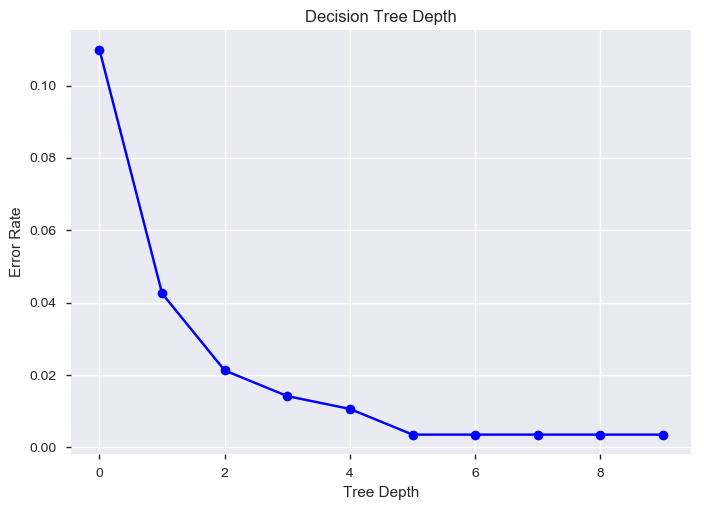

In [38]:
plt.plot(treeDepths, depthErrors, 'bo-')
plt.title("Decision Tree Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Error Rate")
plt.show()

### Decision Tree Precision-Recall Curve

In [41]:
dtThresholds = ut.generateThresholds(0.132, 0.95, 9, 4, Labels)

In [42]:
dtPrecisions = []
dtRecalls = []
model = dt.DecisionTree(Target, maxDepth=3)
for t in dtThresholds:
    model.probThresholds = t
    model.train(Training, quiet=True)
    pred = model.classify(Test.drop([Target], axis=1))
    matrix = ut.buildConfusionMatrix(pred["Prediction"], Test[Target], Labels)
    precision, recall = ut.getPrecisionsAndRecalls(matrix, Labels)
    
    dtPrecisions.append(precision)
    dtRecalls.append(recall)

In [43]:
dtOrdinaryPr = []
dtLegendaryPr = []
dtUltraBeastPr = []
for p, r in zip(dtPrecisions, dtRecalls):
    dtOrdinaryPr.append((r["Ordinary"], p["Ordinary"]))
    dtLegendaryPr.append((r["Legendary"], p["Legendary"]))
    dtUltraBeastPr.append((r["Ultra Beast"], p["Ultra Beast"]))

# Sort by recall. (recall, precision)
dtOrdinaryPr.sort(key=lambda x: x[0])
dtLegendaryPr.sort(key=lambda x: x[0])
dtUltraBeastPr.sort(key=lambda x: x[0])

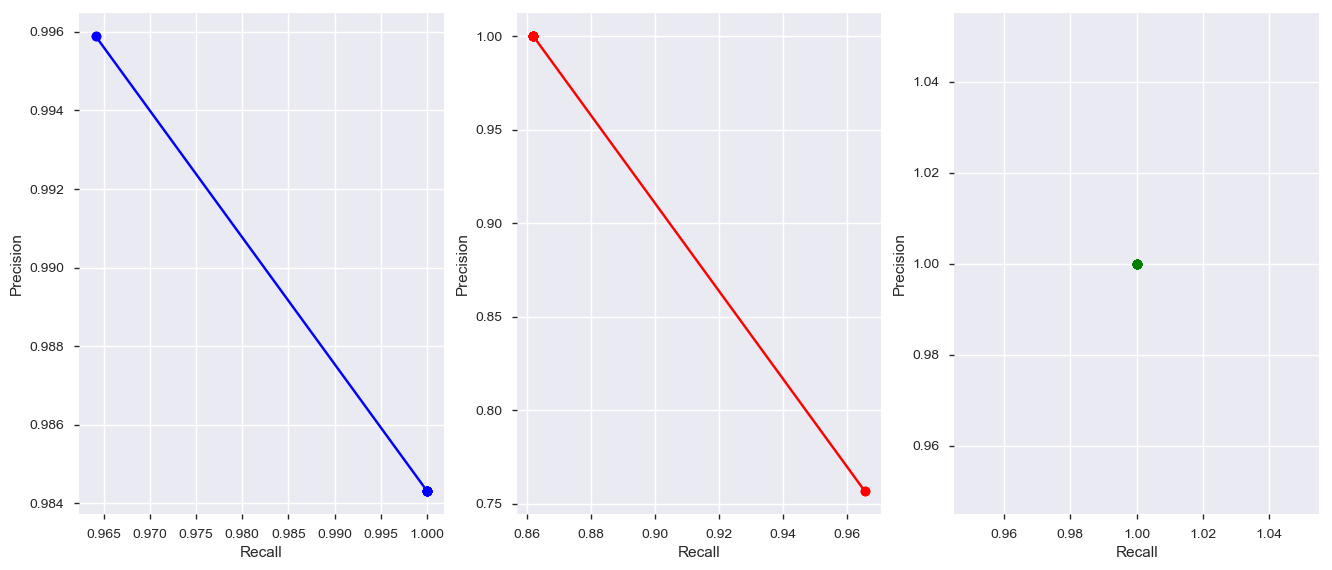

In [44]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6.5))
    
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].plot([i[0] for i in dtOrdinaryPr], [i[1] for i in dtOrdinaryPr], 'bo-')

axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].plot([i[0] for i in dtLegendaryPr], [i[1] for i in dtLegendaryPr], 'ro-')

axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].plot([i[0] for i in dtUltraBeastPr], [i[1] for i in dtUltraBeastPr], 'go-')

### Decision Tree K Fold Cross Validation

In [45]:
dtKErrors = ut.kFoldCrossValidationResult(10, Target, Training, dtree)

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k exceeds the label with the smallest number of data points. k=10, smallest # of data points of a label=9. Return early...


In [46]:
# Compute the and means, variances, and standard deviations of the k fold cross validation result
means = [sum(e) / len(e) for e in dtKErrors]
stds =  []
variances = []

for e, m in zip(dtKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

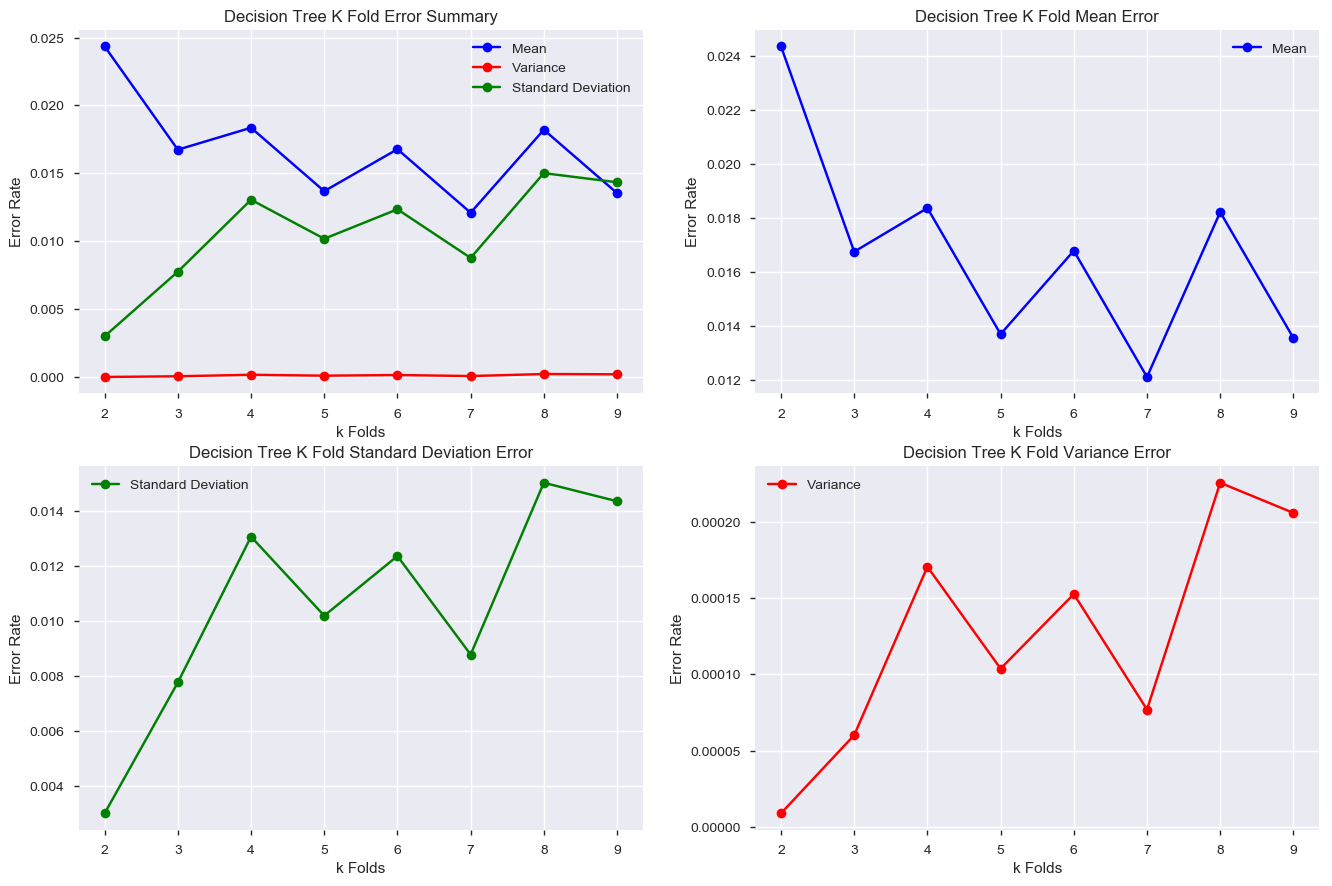

In [47]:
# Plot the error rates represented by the mean, variance, and standard deviation
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

kRange = range(2, 2 + len(means))

axes[0, 0].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Decision Tree K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 1].set_title("Decision Tree K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[1, 1].set_title("Decision Tree K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Decision Tree K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

## <font color="red">Naive Bayes</font>

In [48]:
# Use Naive Bayes to train on the training set and predict on the test data set
nBayes = nb.NaiveBayes(Target, Labels)
nBayes.train(Training)
nbPred = nBayes.classify(Test.drop([Target], axis=1))

Function "train" took 4.98 seconds to complete
Function "classify" took 14.02 seconds to complete


In [49]:
nbMatrix = ut.buildConfusionMatrix(nbPred["Prediction"], Test[Target], Labels)
nbPrecisions, nbRecalls = ut.getPrecisionsAndRecalls(nbMatrix, Labels)
nbFScores = ut.computeFScores(nbPrecisions, nbRecalls)
"Error: {0:.2f}%".format(ut.computeError(nbPred["Prediction"], Test["Group"]) * 100)

'Error: 24.47%'

### Naive Bayes Confustion Matrix

In [50]:
nbMatrix

,Predicted Legendary,Predicted Ordinary,Predicted Ultra Beast,Total
Actual Legendary,15,1,13,29
Actual Ordinary,1,196,54,251
Actual Ultra Beast,0,0,2,2
Total,16,197,69,282


In [51]:
nbPrecisions

{'Legendary': 0.9375,
 'Ordinary': 0.9949238578680203,
 'Ultra Beast': 0.028985507246376812}

In [52]:
nbRecalls

{'Legendary': 0.5172413793103449,
 'Ordinary': 0.7808764940239044,
 'Ultra Beast': 1.0}

In [53]:
print("Average across all labels:", nbFScores[0])
nbFScores[1]

Average across all labels: 0.5326682316118935


{'Legendary': 0.6666666666666667,
 'Ordinary': 0.8749999999999999,
 'Ultra Beast': 0.05633802816901409}

### Naive Bayes ROC Curve

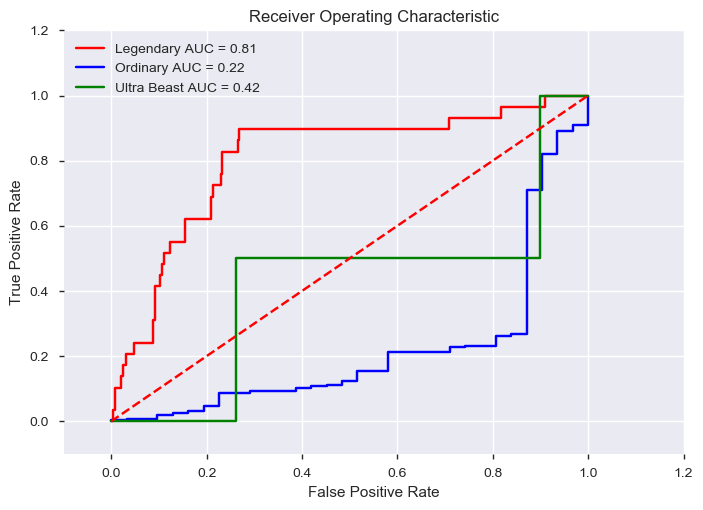

In [54]:
# For each label, treat other labels as "negative"
for label in Labels:
    c = LabelColors[label]
    fpr, tpr, thresholds = roc_curve(y_true=Test[Target], y_score=[v[1] for v in nbPred.values], pos_label=label)
    rocAuc = auc(fpr, tpr)
    plt.plot(fpr, tpr, c, label='{0} AUC = {1:.2f}'.format(label, rocAuc))
    
plt.title('Receiver Operating Characteristic')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Naive Bayes Precision-Recall Curve

In [55]:
nbThresholds = ut.generateThresholds(0.132, 0.95, 9, 4, Labels)

In [57]:
nbPrecisions = []
nbRecalls = []
model = nb.NaiveBayes(Target, Labels)
for t in nbThresholds:
    model.probThresholds = t
    model.train(Training, quiet=True)
    pred = model.classify(Test.drop([Target], axis=1), quiet=True)
    matrix = ut.buildConfusionMatrix(pred["Prediction"], Test[Target], Labels)
    precision, recall = ut.getPrecisionsAndRecalls(matrix, Labels)
    
    nbPrecisions.append(precision)
    nbRecalls.append(recall)

In [58]:
nbOrdinaryPr = []
nbLegendaryPr = []
nbUltraBeastPr = []
for p, r in zip(nbPrecisions, nbRecalls):
    nbOrdinaryPr.append((r["Ordinary"], p["Ordinary"]))
    nbLegendaryPr.append((r["Legendary"], p["Legendary"]))
    nbUltraBeastPr.append((r["Ultra Beast"], p["Ultra Beast"]))

# Sort by recall. (recall, precision)
nbOrdinaryPr.sort(key=lambda x: x[0])
nbLegendaryPr.sort(key=lambda x: x[0])
nbUltraBeastPr.sort(key=lambda x: x[0])

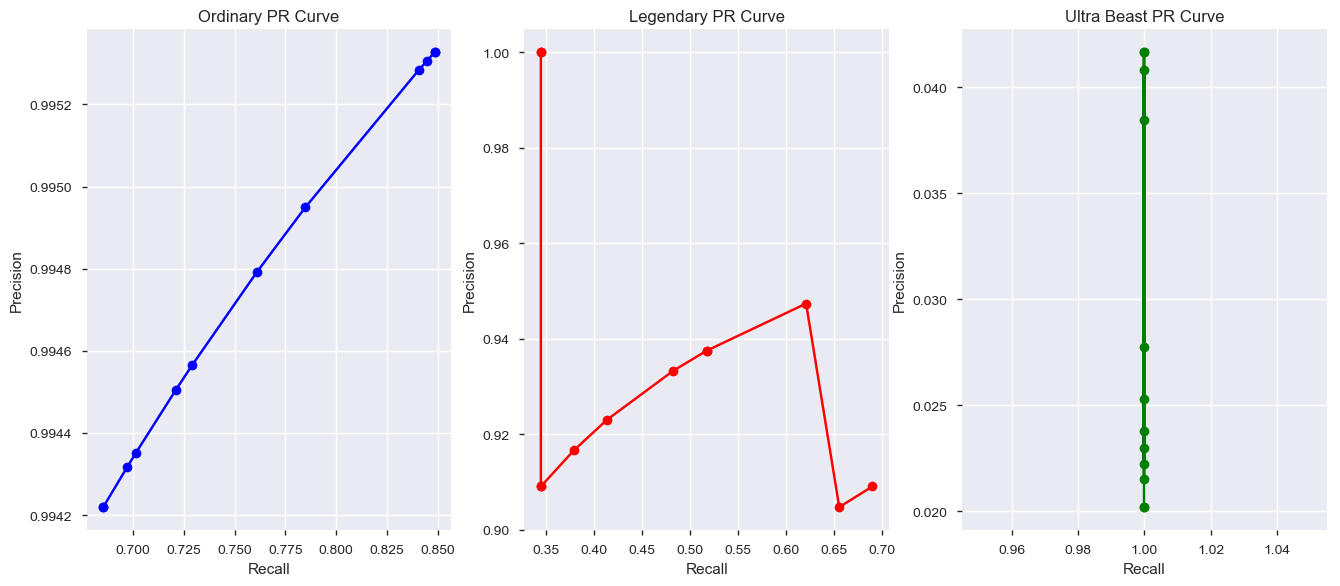

In [59]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,6.5))

axes[0].set_title("Ordinary PR Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].plot([i[0] for i in nbOrdinaryPr], [i[1] for i in nbOrdinaryPr], 'bo-')

axes[1].set_title("Legendary PR Curve")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].plot([i[0] for i in nbLegendaryPr], [i[1] for i in nbLegendaryPr], 'ro-')

axes[2].set_title("Ultra Beast PR Curve")
axes[2].set_xlabel("Recall")
axes[2].set_ylabel("Precision")
axes[2].plot([i[0] for i in nbUltraBeastPr], [i[1] for i in nbUltraBeastPr], 'go-')

### Perform K Fold Cross Validations

In [60]:
nbKErrors = ut.kFoldCrossValidationResult(10, Target, Training, nBayes)

k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k exceeds the label with the smallest number of data points. k=10, smallest # of data points of a label=9. Return early...


In [61]:
# Compute the and means, variances, and standard deviations of the k fold cross validation result
means = [sum(e) / len(e) for e in nbKErrors]
stds =  []
variances = []

for e, m in zip(nbKErrors, means):
    v = sum(map(lambda x: (x - m)**2, e)) / len(e)
    s = math.sqrt(v)
    variances.append(v)
    stds.append(s)

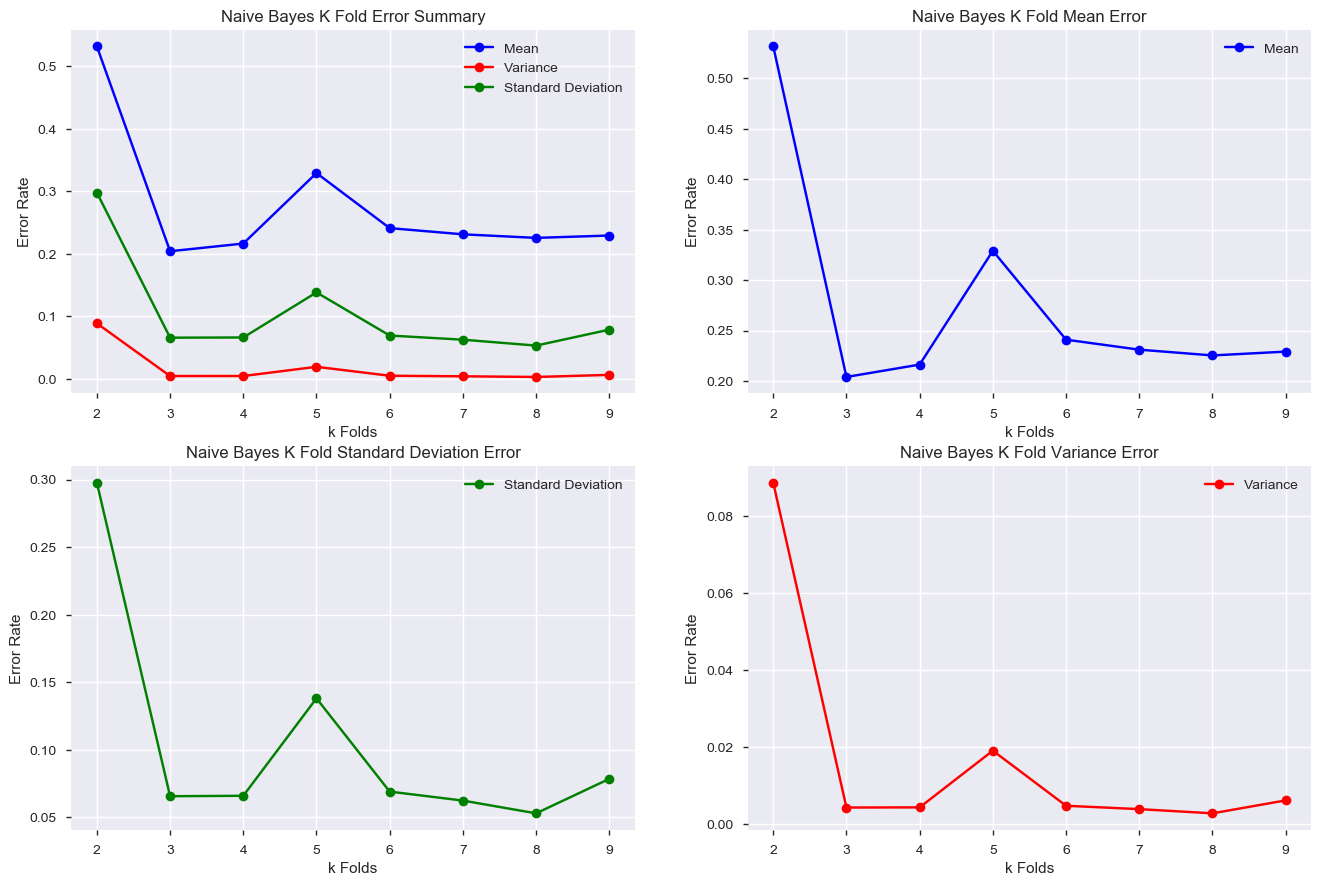

In [62]:
# Plot the error rates represented by the mean, variance, and standard deviation
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
figure.subplots_adjust(top=1.5, bottom=0.5)

kRange = range(2, 2 + len(means))

axes[0, 0].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 0].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[0, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[0, 0].set_title("Naive Bayes K Fold Error Summary")
axes[0, 0].set_xlabel("k Folds")
axes[0, 0].set_ylabel("Error Rate")
axes[0, 0].legend(loc="best")

axes[0, 1].plot([i for i in kRange], means, "bo-", label="Mean")
axes[0, 1].set_title("Naive Bayes K Fold Mean Error")
axes[0, 1].set_xlabel("k Folds")
axes[0, 1].set_ylabel("Error Rate")
axes[0, 1].legend(loc="best")

axes[1, 1].plot([i for i in kRange], variances, "ro-", label="Variance")
axes[1, 1].set_title("Naive Bayes K Fold Variance Error")
axes[1, 1].set_xlabel("k Folds")
axes[1, 1].set_ylabel("Error Rate")
axes[1, 1].legend(loc="best")

axes[1, 0].plot([i for i in kRange], stds, "go-", label="Standard Deviation")
axes[1, 0].set_title("Naive Bayes K Fold Standard Deviation Error")
axes[1, 0].set_xlabel("k Folds")
axes[1, 0].set_ylabel("Error Rate")
axes[1, 0].legend(loc="best")
plt.show()

## <font color="red">Estimating Confidence Interval</font>

In [63]:
from multiprocessing.pool import ThreadPool

In [64]:
dtModel = dt.DecisionTree(Target, maxDepth=3)
nbModel = nb.NaiveBayes(Target, Labels)
pool = ThreadPool(processes=2)

In [65]:
k = 10
training, test = ut.splitData(Target, ReducedData, 0.70)
kTrainings, kTests = ut.kFoldCrossValidation(10, training)

In [66]:
dtErrors = []
nbErrors = []

for kTraining, kTest in zip(kTrainings, kTests):
    kTestTarget = kTest[Target]
    kTest = kTest.drop([Target], axis=1)
    
    t1 = pool.apply_async(dtModel.train, (kTraining,), dict(quiet=True))
    t2 = pool.apply_async(nbModel.train, (kTraining,), dict(quiet=True))

    t1.wait()
    t2.wait()
    
    t3 = pool.apply_async(dtModel.classify, (kTest,), dict(quiet=True))
    t4 = pool.apply_async(nbModel.classify, (kTest,), dict(quiet=True))
    
    dtPred = t3.get()
    nbPred = t4.get()
    
    dtErrors.append(ut.computeError(dtPred["Prediction"], kTestTarget))
    nbErrors.append(ut.computeError(nbPred["Prediction"], kTestTarget))  

In [67]:
tValue = abs(ut.tTest(dtErrors, nbErrors, 10))
"t value is {0}".format(tValue)

't value is 12.512495337674666'

Use this link https://surfstat.anu.edu.au/surfstat-home/tables/t.php to check the p-value. Degree of freedom is k-1 and t value is the value above.

In [68]:
gc.collect()

343